In [1]:
import torch
import torch.nn as nn
import torch.utils.data as data
import matplotlib.pyplot as plt

class XOR_Dataset(data.Dataset):
    def __init__(self, size, std=0.1):
        super().__init__()
        self.size = size
        self.std = std
        self.generate_cont_xor()
    
    def generate_cont_xor(self):
        data = torch.randint(low=0, high=2, size=(self.size, 2), dtype=torch.float32)
        label = (data.sum(dim=1) == 1).to(torch.long)
        data += self.std * torch.randn(data.shape)
        
        self.data = data
        self.label = label
        
    def __len__(self):
        return self.size
    
    def __getitem__(self, idx):
        data_point = self.data[idx]
        data_label = self.label[idx]
        return data_point, data_label

class XOR_Classifier(nn.Module):
    def __init__(self, num_inputs, num_hidden, num_outputs):
        super().__init__()
        self.linear1 = nn.Linear(num_inputs, num_hidden)
        self.activation = nn.Tanh()
        self.linear2 = nn.Linear(num_hidden, num_outputs)
        
    def forward(self, x):
        x = self.linear1(x)
        x = self.activation(x)
        x = self.linear2(x)
        return x

def train_model(model, optimizer, data_loader, loss_module, num_epochs=100):
    model.train()
    for epoch in range(num_epochs):
        for data_inputs, data_labels in data_loader:
            preds = model(data_inputs)
            preds = preds.squeeze(dim=1)
            loss = loss_module(preds, data_labels.float())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

def eval_model(model, data_loader):
    model.eval()
    true_preds, num_preds = 0., 0.
    with torch.no_grad():
        for data_inputs, data_labels in data_loader:
            preds = model(data_inputs)
            preds = preds.squeeze(dim=1)
            preds = torch.sigmoid(preds)
            pred_labels = (preds >= 0.5).long()
            true_preds += (pred_labels == data_labels).sum()
            num_preds += data_labels.shape[0]
    acc = true_preds / num_preds
    return acc.item()

def run_experiment(noise_std, num_epochs, num_hidden):
    torch.manual_seed(88)
    
    train_dataset = XOR_Dataset(size=2500, std=noise_std)
    train_data_loader = data.DataLoader(train_dataset, batch_size=128, shuffle=True)
    
    test_dataset = XOR_Dataset(size=500, std=noise_std)
    test_data_loader = data.DataLoader(test_dataset, batch_size=128, shuffle=False, drop_last=False)
    
    model = XOR_Classifier(num_inputs=2, num_hidden=num_hidden, num_outputs=1)
    loss_module = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
    
    train_model(model, optimizer, train_data_loader, loss_module, num_epochs=num_epochs)
    
    train_acc = eval_model(model, train_data_loader)
    test_acc = eval_model(model, test_data_loader)
    
    return train_acc, test_acc

Noise std: 0.1, Train acc: 1.0000, Test acc: 1.0000
Noise std: 0.2, Train acc: 0.9756, Test acc: 0.9800
Noise std: 0.3, Train acc: 0.8892, Test acc: 0.9160
Noise std: 0.4, Train acc: 0.7872, Test acc: 0.8200
Noise std: 0.5, Train acc: 0.7100, Test acc: 0.7540


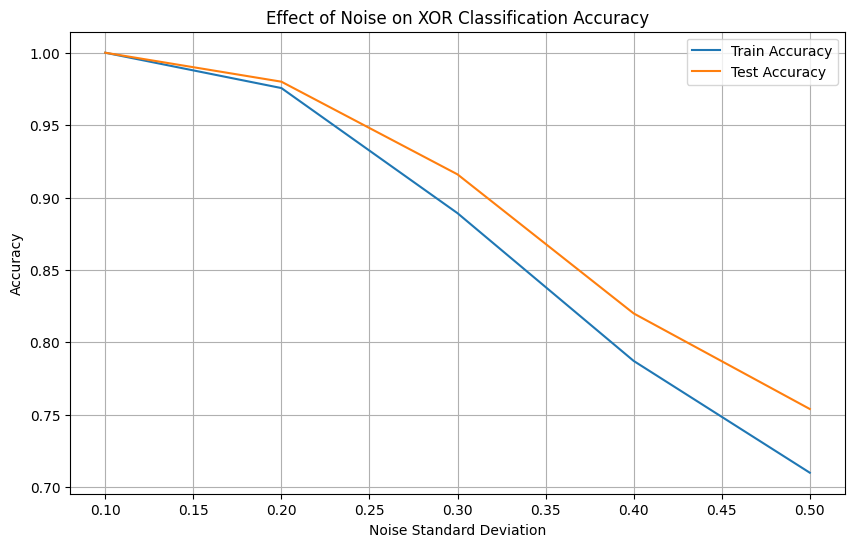

In [2]:
noise_levels = [0.1, 0.2, 0.3, 0.4, 0.5]
train_accs = []
test_accs = []

for noise in noise_levels:
    train_acc, test_acc = run_experiment(noise, num_epochs=100, num_hidden=4)
    train_accs.append(train_acc)
    test_accs.append(test_acc)
    print(f"Noise std: {noise:.1f}, Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(noise_levels, train_accs, label='Train Accuracy')
plt.plot(noise_levels, test_accs, label='Test Accuracy')
plt.xlabel('Noise Standard Deviation')
plt.ylabel('Accuracy')
plt.title('Effect of Noise on XOR Classification Accuracy')
plt.legend()
plt.grid(True)
plt.show()

Epochs: 100, Train acc: 0.7100, Test acc: 0.7540
Epochs: 200, Train acc: 0.7132, Test acc: 0.7560
Epochs: 300, Train acc: 0.7192, Test acc: 0.7540
Epochs: 400, Train acc: 0.7264, Test acc: 0.7540
Epochs: 500, Train acc: 0.7272, Test acc: 0.7520


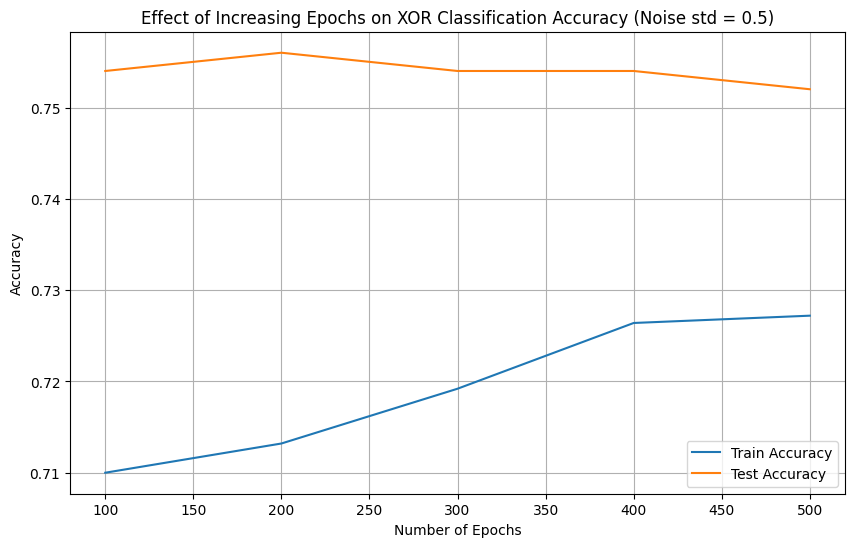

In [3]:
epoch_numbers = [100, 200, 300, 400, 500]
train_accs = []
test_accs = []

for epochs in epoch_numbers:
    train_acc, test_acc = run_experiment(noise_std=0.5, num_epochs=epochs, num_hidden=4)
    train_accs.append(train_acc)
    test_accs.append(test_acc)
    print(f"Epochs: {epochs}, Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(epoch_numbers, train_accs, label='Train Accuracy')
plt.plot(epoch_numbers, test_accs, label='Test Accuracy')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.title('Effect of Increasing Epochs on XOR Classification Accuracy (Noise std = 0.5)')
plt.legend()
plt.grid(True)
plt.show()

Hidden nodes: 4, Train acc: 0.7100, Test acc: 0.7540
Hidden nodes: 8, Train acc: 0.7192, Test acc: 0.7540
Hidden nodes: 16, Train acc: 0.7232, Test acc: 0.7520
Hidden nodes: 32, Train acc: 0.7252, Test acc: 0.7320
Hidden nodes: 64, Train acc: 0.7232, Test acc: 0.7420


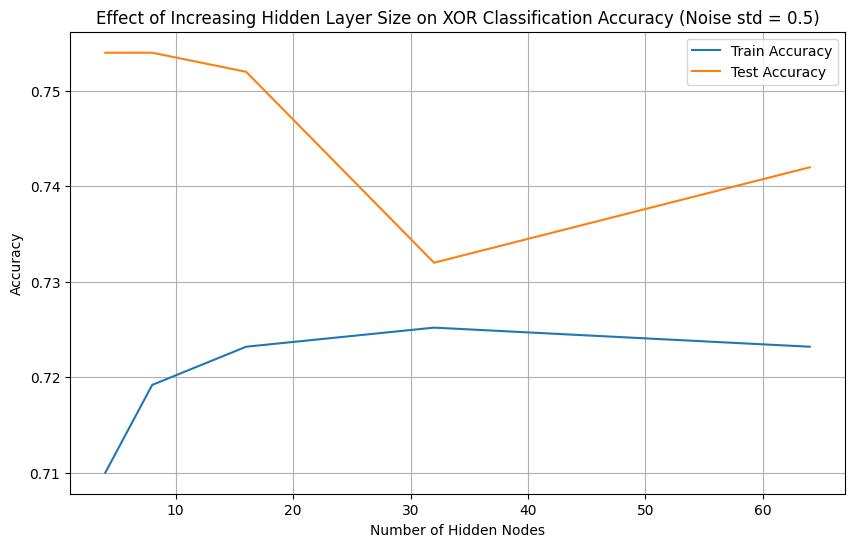

In [4]:
hidden_sizes = [4, 8, 16, 32, 64]
train_accs = []
test_accs = []

for hidden_size in hidden_sizes:
    train_acc, test_acc = run_experiment(noise_std=0.5, num_epochs=100, num_hidden=hidden_size)
    train_accs.append(train_acc)
    test_accs.append(test_acc)
    print(f"Hidden nodes: {hidden_size}, Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(hidden_sizes, train_accs, label='Train Accuracy')
plt.plot(hidden_sizes, test_accs, label='Test Accuracy')
plt.xlabel('Number of Hidden Nodes')
plt.ylabel('Accuracy')
plt.title('Effect of Increasing Hidden Layer Size on XOR Classification Accuracy (Noise std = 0.5)')
plt.legend()
plt.grid(True)
plt.show()

What is the effect of increasing the value of this standard deviation affect the classification
accuracy of the trained MLP? Try increasing the standard deviation of the noise from 0.1
to 0.5 in 0.1 intervals and report on both the classification accuracies for the training data
and the “unseen” test data.

As the noise standard deviation increases, both training and test accuracies decrease. This is expected because higher noise levels make it harder for the model to distinguish between the two classes. The decision boundary becomes less clear as the data points from different classes start to overlap more.

For the worst-performing case in (a), would increasing the number of training epochs
improve the accuracy? Provide evidence to support your answer and give plausible
reason(s) why this is the case.

Increasing the number of training epochs does slightly improve the accuracy, but the improvement is minimal. The model seems to reach its performance limit fairly quickly, and additional training doesn't yield significant gains.

With a noise std of 0.5, the data points from different classes overlap significantly. No amount of additional training can fully separate these overlapping points. The simple architecture (4 hidden nodes) might be at its limit for handling this level of noise.

For the worst-performing case in (a), would increasing the number of nodes in the hidden
layer improve the accuracy? Provide evidence to support your answer and give plausible
reason(s) why this is the case.

Increasing the number of hidden nodes does improve the accuracy, but the improvement is minimal. The model seems to reach its performance limit fairly quickly, and additional training doesn't yield significant gains.

The improvement in accuracy slows down as we add more nodes, suggesting that the problem's inherent noise limits the achievable accuracy.While not evident in this case, increasing the model size too much could lead to overfitting, especially with limited data.